#### Bibliotecas

In [1]:
from datetime import datetime
from time import time
from contextlib import contextmanager
from typing import List, Union

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from minisom import MiniSom

from tsai.all import *

import optuna


from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import torch_optimizer

os.environ["DEVICE"] = "cuda"

## Pré-processamento dos dados

### Cálculo do GPP

In [2]:
@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def constructor_2(path):
    df = pd.read_csv(path, parse_dates=['date'])
    # Definindo a coluna 'system:time_start' como índice
    hora_inicio = df['date'].min().floor('d')
    df.index = hora_inicio + pd.to_timedelta(df.index, unit='h')
    # Removendo a coluna 'system:time_start'
    df = df.drop(['date','.geo'], axis=1)
    df = df.drop('system:index',axis=1)
    return df

def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

def df_xy(x,y):
    x_df = pd.DataFrame(x[:,0]).reset_index().drop('index',axis=1)
    x_df.columns = [f'janela {i}' for i in range(len(x_df.columns))]

    y_df = pd.DataFrame(y).reset_index().drop('index',axis=1)
    y_df.columns = [f'previsao {i}' for i in range(len(y_df.columns))]

    return pd.concat([x_df,y_df],axis=1)

@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def read_data():
    with cwd('dados/Merra/dados_otimizados'):
        dados = []
        for csv in sorted(os.listdir()):
            name = csv.split('_')[1]
            df = pd.read_csv(csv)
            datetime = df['index']
            df.index = pd.to_datetime(datetime)
            df = df['GPP']
            smoothed_csv = ExponentialSmoothing(df, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues
            dados.append(pd.DataFrame(smoothed_csv,columns=[name],index=datetime))
        return dados

gpp_cax, gpp_peru, gpp_santarem = read_data()
gpp_todos = pd.concat([gpp_peru,gpp_santarem,gpp_cax],axis=1)

### Divisão do dataset em treino e teste

In [3]:
train, test = train_test_split(gpp_todos,test_size=0.15,shuffle=False,random_state=1) # Não embaralhado
train_date = train.index
test_date = test.index

gpp_peru_train, gpp_santarem_train, gpp_cax_train = gpp_peru.loc[train_date].copy(),gpp_santarem.loc[train_date].copy(),gpp_cax.loc[train_date].copy()
gpp_peru_test, gpp_santarem_test, gpp_cax_test = gpp_peru.loc[test_date].copy(),gpp_santarem.loc[test_date].copy(),gpp_cax.loc[test_date].copy()

### Criação da janela temporal

In [4]:
peru_x_test,peru_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru_test)                                                                                     
santarem_x_test,santarem_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem_test)
cax_x_test,cax_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax_test)


# Transformação em Dataframe para melhor manipulação dos dados
peru_xtest = pd.DataFrame(peru_x_test.reshape(-1, 8))
peru_ytest = pd.DataFrame(peru_y_test)
peru_ytest['localidade'] = 'peru'

santarem_xtest = pd.DataFrame(santarem_x_test.reshape(-1, 8))
santarem_ytest = pd.DataFrame(santarem_y_test)
santarem_ytest['localidade'] = 'santarem'

cax_xtest = pd.DataFrame(cax_x_test.reshape(-1, 8))
cax_ytest = pd.DataFrame(cax_y_test)
cax_ytest['localidade'] = 'caxiuana'

x_test_df = pd.concat([peru_xtest,
                       santarem_xtest,
                       cax_xtest,
                       ],
                      ignore_index=True)


y_test_df = pd.concat([pd.DataFrame(peru_ytest),
                       pd.DataFrame(santarem_ytest),
                       pd.DataFrame(cax_ytest),
                       ],
                      ignore_index=True)


X_test = x_test_df.values.reshape(-1, 1, 8) # (n° observações, características, janela de observação)
y_test = y_test_df.drop('localidade',axis=1).values
y_labels = y_test_df['localidade']

In [5]:
peru_x_train,peru_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru_train) 
santarem_x_train,santarem_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem_train)
cax_x_train,cax_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax_train)

peru_df = df_xy(peru_x_train,peru_y_train)
santarem_df = df_xy(santarem_x_train,santarem_y_train)
cax_df = df_xy(cax_x_train,cax_y_train)

peru_df['localidade'] = 'peru'
santarem_df['localidade'] = 'santarem'
cax_df['localidade'] = 'caxiuana'


gpp_geral = pd.concat([peru_df,santarem_df,cax_df]).reset_index().drop('index',axis=1)

### Geração de Características das séries

In [16]:
previsao = [f'previsao {i}' for i in range(0,8)]

X = gpp_geral.drop(columns=['localidade']).drop(columns=previsao)  # Aqui ficam 8 colunas representado instantes da janela temporal
y = gpp_geral[previsao] # Aqui fica os próximos 8 valores da sequência
z = gpp_geral[['localidade']]

ts_features_df = get_ts_features(X=X.values.reshape(X.shape[0],1,X.shape[1]),y=y.values,features='efficient')
ts_features_df = ts_features_df.dropna(axis=1) # Removendo colunas com valores nulos

Feature Extraction: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


### Clusterização com SOM

In [18]:
norm = preprocessing.Normalizer()

datos = norm.fit_transform(ts_features_df.values)

map_size = round(np.sqrt(round(5 * np.sqrt(len(ts_features_df))))) # arredondando pra um inteiro com raiz exata = 324 = 18x18

som_shape = (map_size, map_size)
som = MiniSom(som_shape[0], som_shape[1], datos.shape[1],neighborhood_function='gaussian',activation_distance='euclidean',random_seed=1)

som.train_batch(datos, 100, verbose=False)
print(som.quantization_error(datos))

winner_coordinates = np.array([som.winner(x) for x in datos]).T

cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
gpp_geral['cluster'] = np.array(cluster_index)

# Contar o número de ocorrências de cada cluster por localidade
cluster_counts = gpp_geral.groupby(['localidade', 'cluster']).size()

# Filtrar os clusters para apenas os que possuem mais de 6 ocorrências para remover outliers
valid_clusters = cluster_counts[cluster_counts > 6].index

# Manter apenas as linhas cujo cluster e localidade estão nos clusters e localidades válidos
gpp_geral = gpp_geral[gpp_geral.set_index(['localidade', 'cluster']).index.isin(valid_clusters)].copy()

0.16470571190083066


### Divisão Final do Dataset

In [19]:
previsao = [f'previsao {i}' for i in range(0,8)]
X = gpp_geral.drop(columns=['localidade', 'cluster']).drop(columns=previsao) 
y = gpp_geral[previsao]
z = gpp_geral[['localidade','cluster']]

# Dividir os dados em treino e validação estratificados por 'localidade' e 'cluster'
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.177, stratify=z,random_state=1)

train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
X_train = train_data.drop(columns=previsao)
y_train = train_data[previsao]

val_data = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
X_val = val_data.drop(columns=previsao)
y_val = val_data[previsao]

X_train_np = np.array(X_train)
X_val_np = np.array(X_val)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
y_test_np = np.array(y_test)

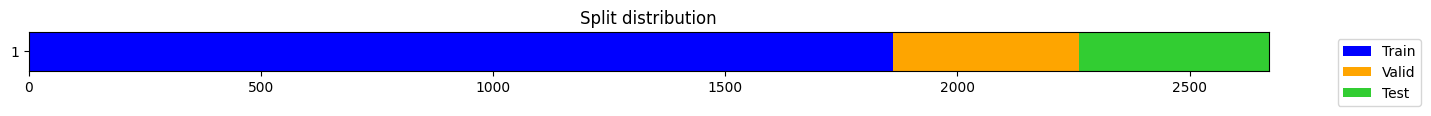

[1861, 401, 408]

In [20]:
X, y, splits = combine_split_data(xs=[X_train_np, X_val_np, X_test_np], ys=[y_train_np, y_val_np, y_test_np])
plot_splits(splits)

tfms = [None, TSForecasting()]
get_splits_len(splits) # [1872, 401, 408] ~= 70%,15%,15%

### Testes com os Modelos

In [33]:
archs = [
         (XCMPlus, {}),
         (ConvTranPlus, {}),
         (TSSequencerPlus, {}),      # Arquiteturas que estou testando (ainda arbitrário).
         (RNNPlus, {}),                         #Os dicionários do lado do nome de cada arquitetura são específicos dos parâmetros
         (ResNetPlus, {}),                              # EX: (LSTM, {'n_layers':1, 'bidirectional': False})
         (InceptionTimePlus, {}),
         (TSTPlus, {}),
         (TransformerLSTMPlus, {}),
         (XceptionTimePlus, {}),
         (TransformerGRUPlus, {}),
         (PatchTST, {}),

        ]

In [ ]:
def test_archs(epochs):
    results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'mae_valid','rmse_valid','mae_test','rmse_test','time'])
    i=0
    for _, (arch, k) in enumerate(archs):
        print(arch.__name__)
        learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=TSStandardize(), arch=arch, metrics=[mae,rmse],device=default_device(),loss_func=HuberLoss('mean'))
        lr = learn.lr_find() # learning rate find
        start = time.time()
        learn.fit_one_cycle(epochs, lr_max=lr.valley)
        elapsed = time.time() - start
        vals = learn.recorder.values[-1]
        raw_preds, target, _ = learn.get_X_preds(X[splits[2]], y[splits[2]])
        mae_test = mean_absolute_error(raw_preds.flatten(),target.flatten())
        mse_test = mean_squared_error(raw_preds.flatten(),target.flatten())
        rmse_test = np.sqrt(mse_test)
        results.loc[i] = [arch.__name__, k, count_parameters(learn.model), vals[0], vals[1], vals[2],vals[3],mae_test,rmse_test, int(elapsed)]
        results.sort_values(by=['mae_valid'], ascending=False, kind='stable', ignore_index=True, inplace=True)
        clear_output()
        display(results)
        i+=1
    results.to_csv(f'resultados_{epochs}_epocas.csv')

for epocas in range(50,350,50):
    test_archs(epocas)

In [ ]:
# def objective(trial):
#     # Categorical parameter
#     #arch_name = trial.suggest_categorical('arch',list(architectures.keys()))

#     nf = trial.suggest_int('nf',128,384)

#     fc_dropout = trial.suggest_float('fc_dropout', 0.0, 0.8)

#     window_perc = trial.suggest_float('window_perc', 0.1, 0.8)

#     arch_config = {
#         'window_perc': window_perc,
#         'nf': nf,
#         'fc_dropout': fc_dropout,
#     }
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps

#     #learning_rate_model = trial.suggest_float("learning_rate_model", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
#     Huber_delta = trial.suggest_float("Huber_delta", 1, 2)
    
#     arch = XCMPlus

#     learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms,
#                          batch_tfms=TSStandardize(),arch=f"{arch.__name__}",
#                          arch_config= arch_config,
#                          #cbs=[ShowGraph(),PredictionDynamics(alpha=.5, size=75)],
#                          loss_func=HuberLoss('mean',Huber_delta),seed=1)
#     with ContextManagers([learn.no_logging(), learn.no_bar()]):
#         for epoch in range(100):
#             learn.fit_one_cycle(1,lr_max=learning_rate)
#             # Report intermediate value
#             intermediate_value = learn.recorder.values[-1][1]
#             trial.report(intermediate_value, epoch)
#             # Check if trial should be pruned
#             if trial.should_prune():
#                 raise optuna.TrialPruned()
#     with open("./optuna_tests/{}.pickle".format(trial.number), "wb") as fout:
#         pickle.dump(learn, fout)
#     return intermediate_value


# study = run_optuna_study(objective,sampler= optuna.samplers.TPESampler(n_startup_trials=100),
#                           pruner=optuna.pruners.HyperbandPruner(min_resource=1, max_resource=100, reduction_factor=3, bootstrap_count=5),
#                           n_trials=1000,gc_after_trial=True,direction="minimize",show_plots=False)

In [42]:
# with open("{}.pickle".format(study.best_trial.number), "rb") as fin:
#     learner = pickle.load(fin)

In [43]:
# raw_preds, target, preds = learner.get_X_preds(X[splits[2]], y[splits[2]])
# mae_test = mean_absolute_error(raw_preds,target)
# mse_test = mean_squared_error(raw_preds,target)
# rmse_test = np.sqrt(mse_test)
# r2_test = r2_score(y_pred=raw_preds,y_true=target)
# print(r2_test)
# print(mae_test)
# print(rmse_test)
# print(np.corrcoef(raw_preds.flatten(), target.flatten()))

0.6016401232524076
1.0172238
1.3786435
[[1.         0.78166711]
 [0.78166711 1.        ]]


In [44]:
# preds_df = pd.concat([pd.DataFrame(raw_preds),y_labels.to_frame()],axis=1)
# target_df = pd.concat([pd.DataFrame(y_test),y_labels.to_frame()],axis=1)

# dfs_preds = {}
# dfs_target = {}

# for localidade in preds_df['localidade'].unique():
#     dfs_preds[localidade] = preds_df[preds_df['localidade'] == localidade]

# for localidade in target_df['localidade'].unique():
#     dfs_target[localidade] = target_df[target_df['localidade'] == localidade]

# # Acessando os DataFrames separados

# df_peru_pred = dfs_preds['peru'].drop('localidade',axis=1)
# df_santarem_pred = dfs_preds['santarem'].drop('localidade',axis=1)
# df_caxiuana_pred = dfs_preds['caxiuana'].drop('localidade',axis=1)

# df_peru_target = dfs_target['peru'].drop('localidade',axis=1)
# df_santarem_target = dfs_target['santarem'].drop('localidade',axis=1)
# df_caxiuana_target = dfs_target['caxiuana'].drop('localidade',axis=1)

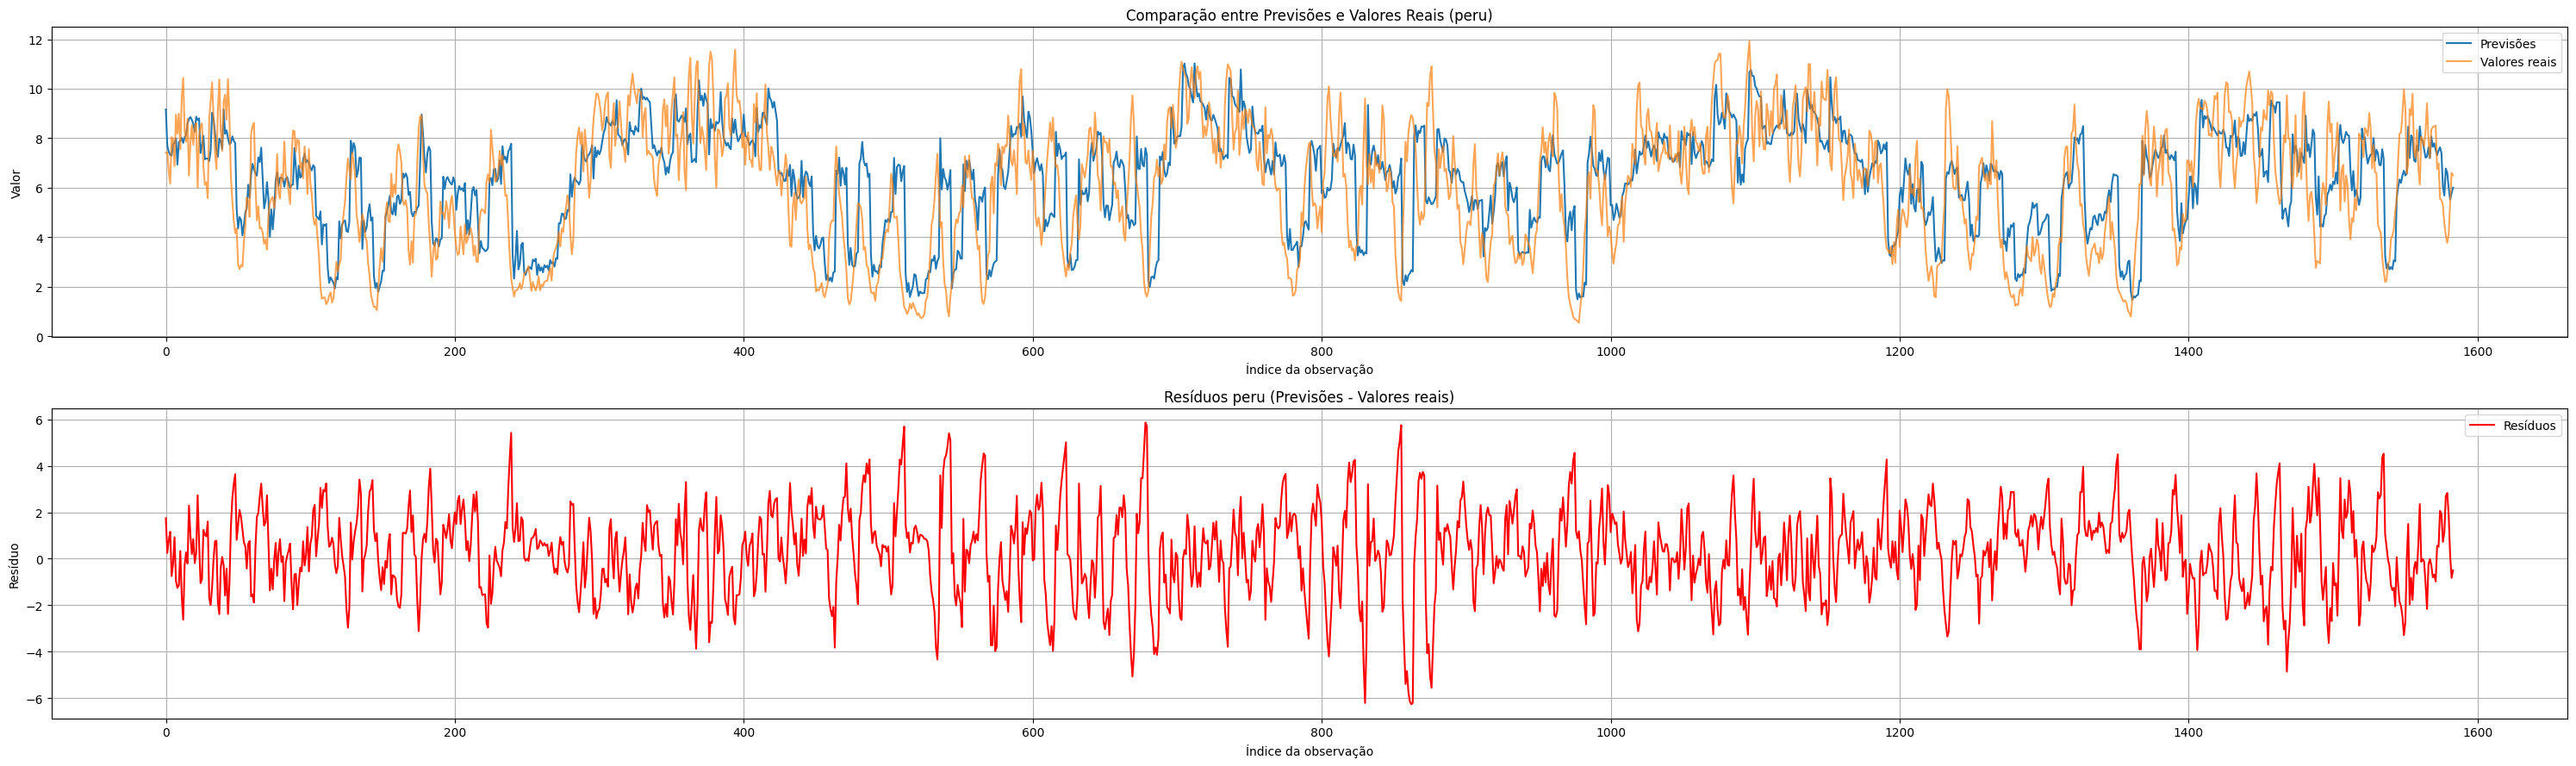

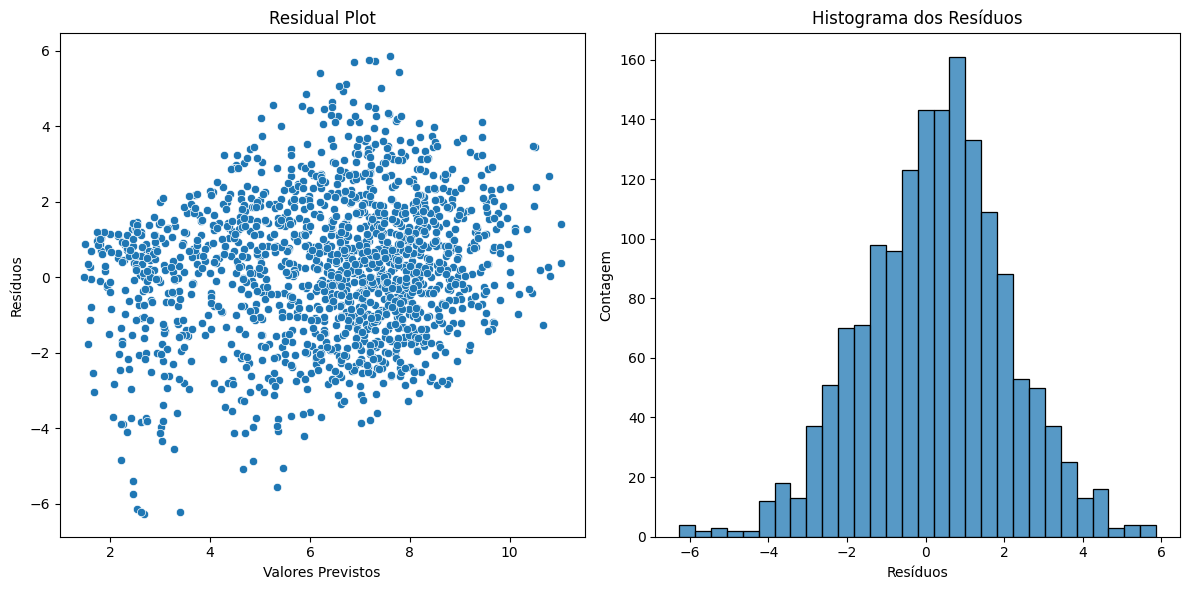

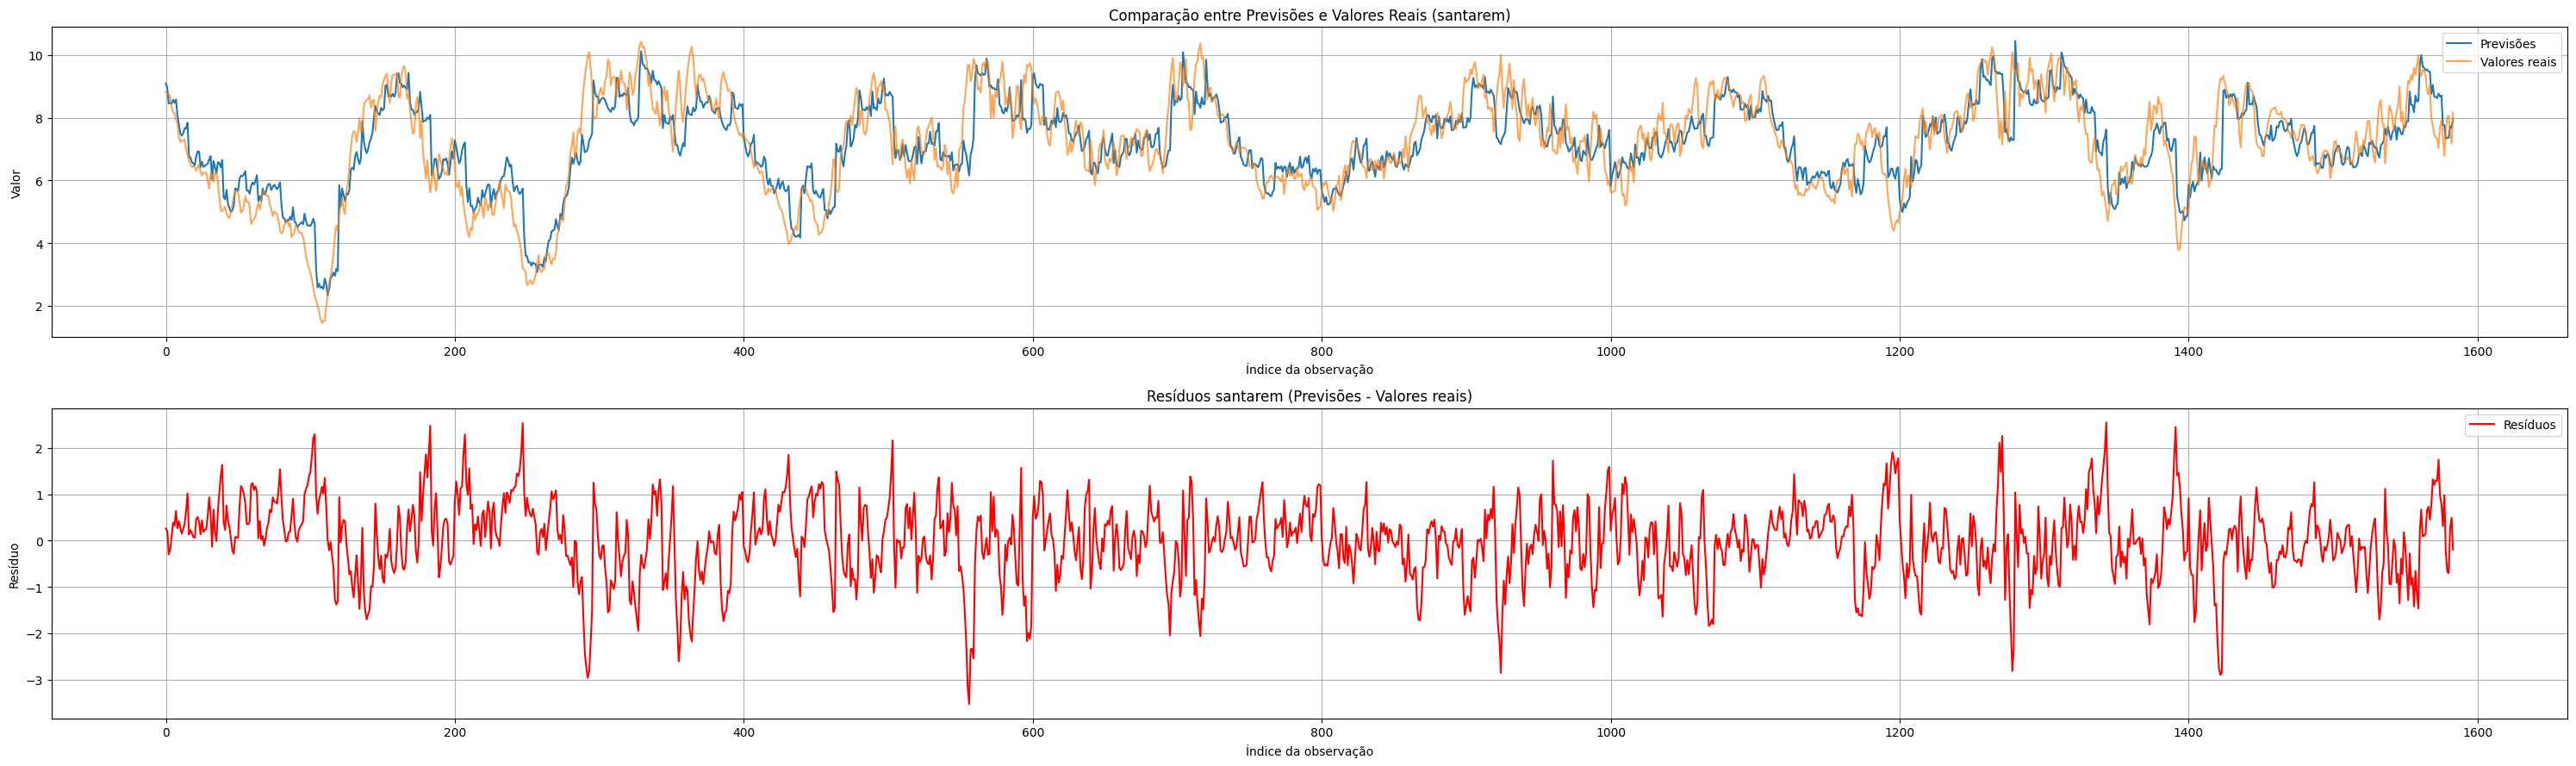

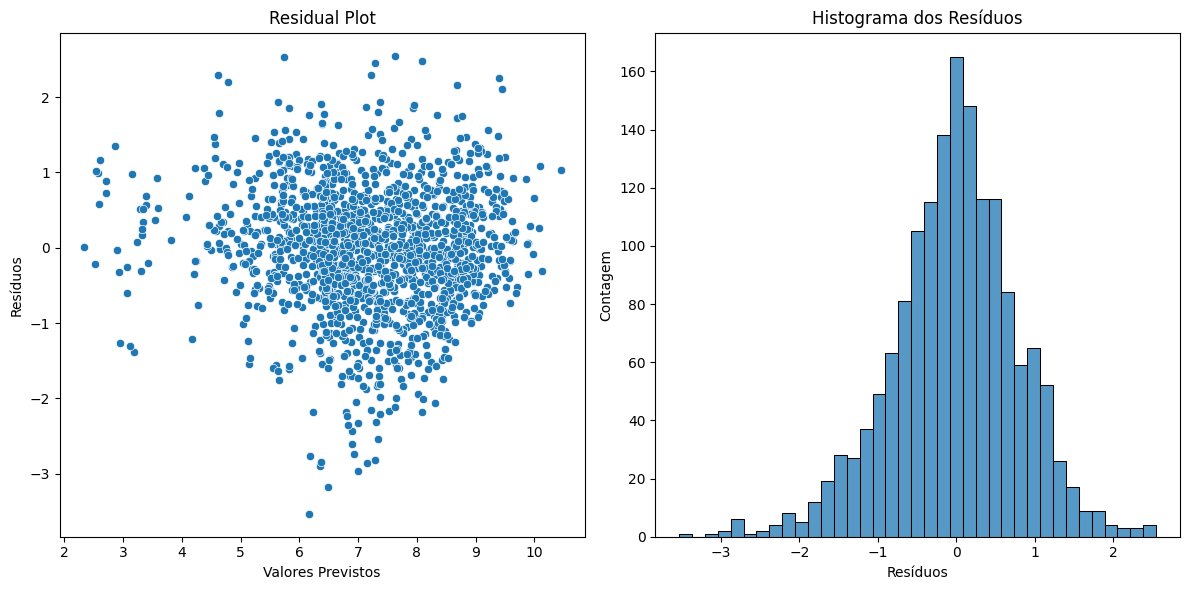

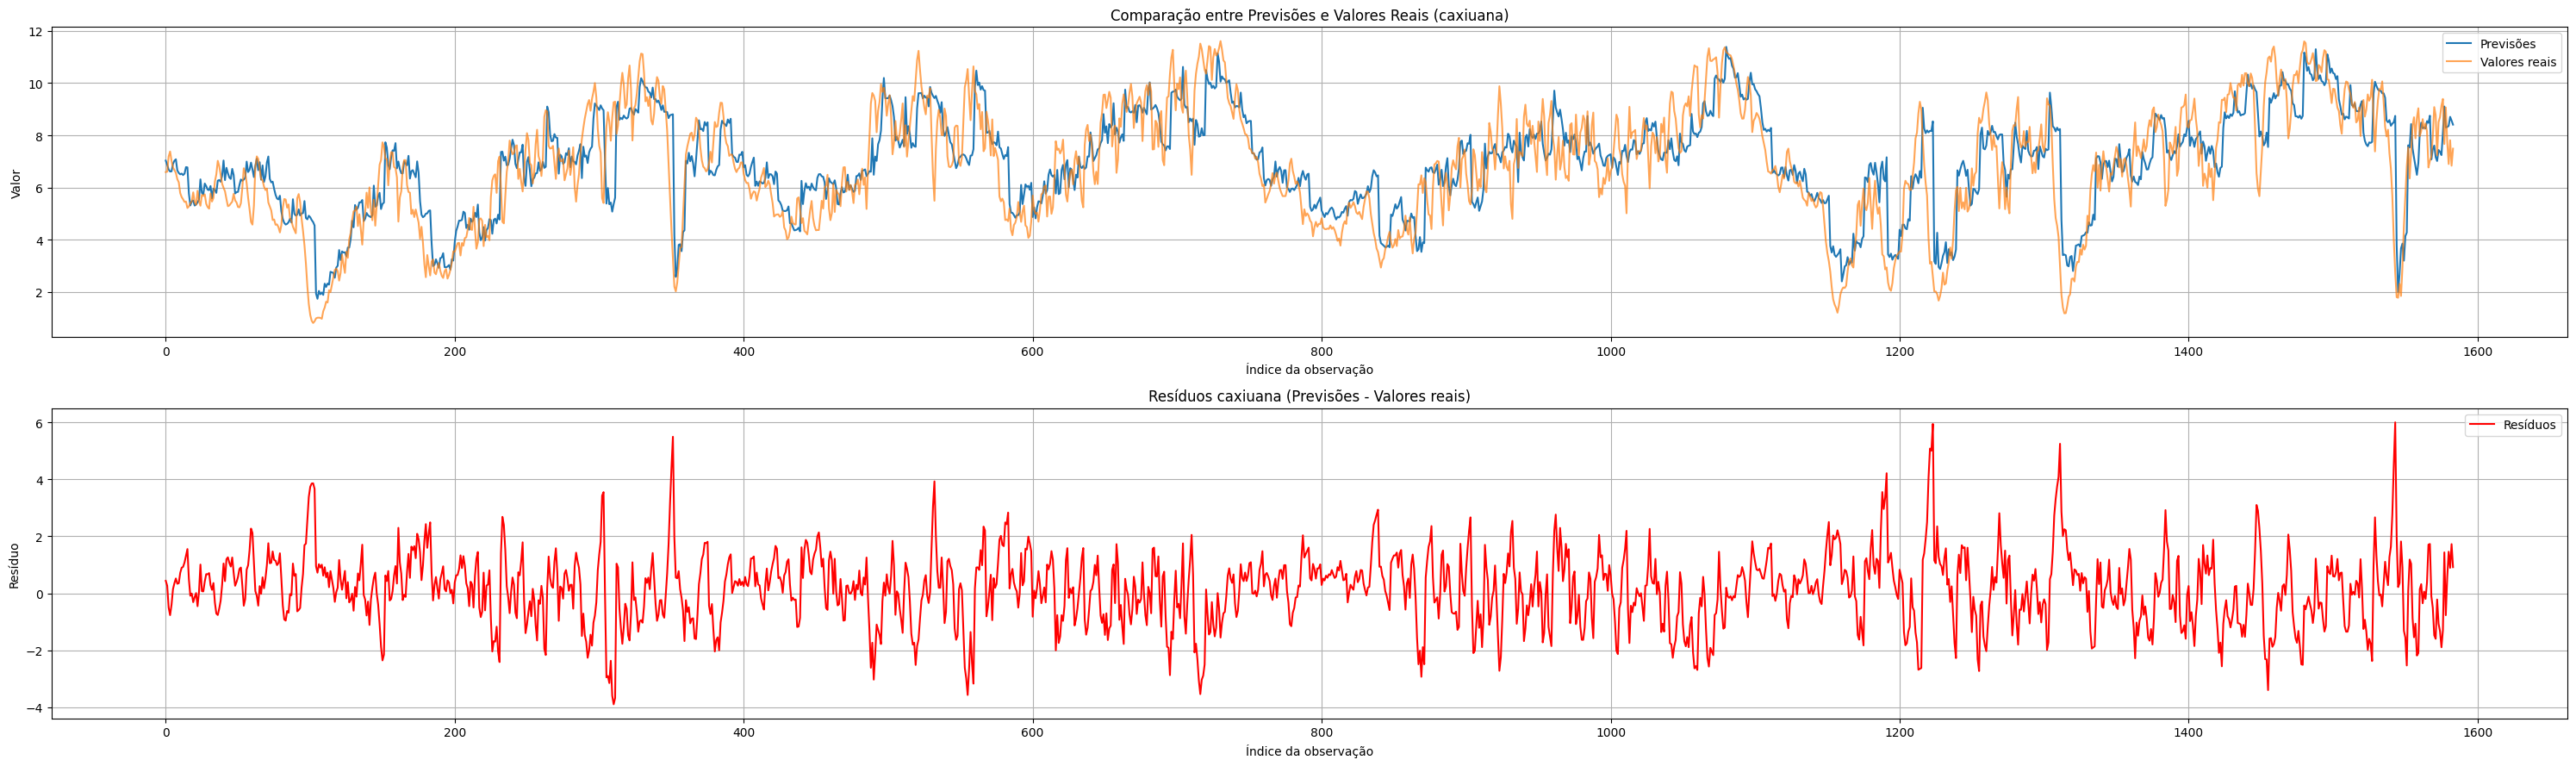

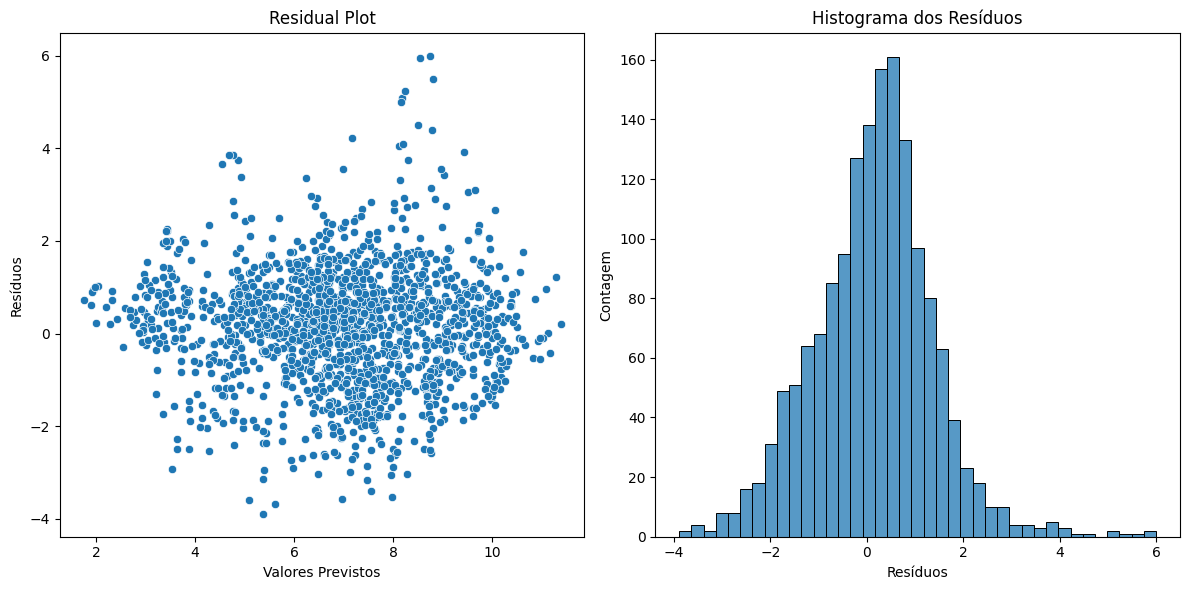

,peru,santarem,caxiuana
R²,0.438613,0.736042,0.681917
MAE,1.468186,0.619981,0.963504
RMSE,1.859346,0.814057,1.257821
Corr,0.690721,0.859565,0.830184


In [46]:
# def get_summary(df_pred,df_target):
#     results = {}
#     for i in dfs_preds:
#         mae_test = mean_absolute_error(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
#         mse_test = mean_squared_error(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
#         rmse_test = np.sqrt(mse_test)
#         r2_test = r2_score(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
#         results[i] = [r2_test,mae_test,rmse_test,np.corrcoef(df_pred[i].drop('localidade',axis=1).values.flatten(), df_target[i].drop('localidade',axis=1).values.flatten())[0][1]]

#         residuos = df_pred[i].drop('localidade',axis=1).values - df_target[i].drop('localidade',axis=1).values
#         plt.figure(figsize=(30, 9))
#         plt.subplot(2, 1, 1)
#         plt.plot(df_pred[i].drop('localidade',axis=1).values.flatten(), label='Previsões', alpha=1)
#         plt.plot(df_target[i].drop('localidade',axis=1).values.flatten(), label='Valores reais', alpha=0.7)
#         plt.xlabel('Índice da observação')
#         plt.ylabel('Valor')
#         plt.title(f'Comparação entre Previsões e Valores Reais ({i})')
#         plt.legend()
#         plt.grid(True)
        
#         plt.subplot(2, 1, 2)
#         plt.plot(residuos.flatten(), label='Resíduos', color='red')
#         plt.xlabel('Índice da observação')
#         plt.ylabel('Resíduo')
#         plt.title(f'Resíduos {i} (Previsões - Valores reais)')
#         plt.legend()
#         plt.grid(True)

#         plt.tight_layout()
#         plt.show()

#         residuos_flatten = residuos.flatten()

#         # Criar figura e eixos para o subplot
#         fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#         # Plot do residual plot
#         sns.scatterplot(x=df_pred[i].drop('localidade',axis=1).values.flatten(), y=residuos_flatten, ax=axes[0])
#         axes[0].set_title('Residual Plot')
#         axes[0].set_xlabel('Valores Previstos')
#         axes[0].set_ylabel('Resíduos')

#         # Plot do histograma dos resíduos
#         sns.histplot(residuos_flatten, ax=axes[1])
#         axes[1].set_title('Histograma dos Resíduos')
#         axes[1].set_xlabel('Resíduos')
#         axes[1].set_ylabel('Contagem')

#         # Ajuste o layout
#         plt.tight_layout()

#         # Mostrar o subplot
#         plt.show()

#     return pd.DataFrame(results,index=['R²','MAE','RMSE','Corr'])

# display(get_summary(dfs_preds,dfs_target))